In [1]:
import os
import subprocess

import aquamonitor as am
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rioxarray as rio
import rpy2.rinterface
import seaborn as sn
import verde as vd
import xarray as xr

%load_ext rpy2.ipython

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Interpolating TOC and NO3 data for Norway over space and time

## Initial data exploration

As part of the critical loads project, we would like to be able to predict TOC and NO3 concentrations in surface waters for any point in time and space `(x, y, t)` in Norway.

There are various ways of doing this. This notebook tries an initial exploration using of Generalised Additive Models (GAMs) implemented in R using `mgcv`.

**Note:** This notebook is fairly rough. In particular, I need to check/improve the choice of stations for representing temporal trends. 

## 1. Get Water chemistry data

The "1000 Lakes" surveys in 1995 and 2019 provide good spatial coverage, but only two time points. We also have the tidstrendsjøer (which I think is called the `BILOK` dataset in Aquamonitor?), which comprises 78 stations in Norway with regular, long-term monitoring. These are less spatially extensive, but provide a good record of temporal trends.

In [3]:
# Login to AM
token = am.login()

Please enter your credentials.


Username:  ········
Password:  ········


In [4]:
# Period of interest
st_yr = 1995
end_yr = 2019

# Output netCDF to create
nc_path = r"/home/jovyan/shared/critical_loads/norway_interpolated_toc_no3_1995-2019.nc"

st_dt = f"01.01.{st_yr}"
end_dt = f"31.12.{end_yr}"

In [5]:
def tidy_water_chem(df):
    """Tidy raw water chemistry data from Aquamonitor. Gets just TOC 
    and NO3 data for surface samples, and calculates annual means for
    each site. 
    
    Note: In Aquamonitor there are two relevant parameters for NO3: 
    'NO3+NO2-N' and 'NO3-N'. The code here combines them into a single 
    series called 'NO3' i.e. NO2 is assumed to be negligible.
    """
    # Just pars of interest
    par_list = ["TOC", "NO3+NO2-N", "NO3-N"]
    df = df.query("parameter_name in @par_list")

    # Only surface samples
    df = df.query("(depth1 == 0) and (depth2 == 0)")

    # Add year
    df["year"] = df["sample_date"].dt.year

    # Tidy and average duplicates
    df["par_unit"] = df["parameter_name"] + "_" + df["unit"]
    df.drop(
        [
            "project_id",
            "project_name",
            "station_code",
            "depth1",
            "depth2",
            "sample_date",
            "parameter_name",
            "unit",
            "flag",
        ],
        axis="columns",
        inplace=True,
    )
    id_cols = ["station_id", "station_name", "year", "par_unit"]
    df = df.groupby(id_cols).mean()
    df = df.unstack("par_unit")
    df.columns = df.columns.get_level_values(1)
    df.reset_index(inplace=True)

    # Most samples report NO3+NO2, but some just have NO3. Use NO3+NO2
    # where possible and patch with NO3
    df["NO3+NO2-N_µg/l"] = df["NO3+NO2-N_µg/l"].combine_first(df["NO3-N_µg/l"])

    # Remove special chars from col names
    df.rename(
        {"TOC_mg/l": "TOC_mgpl", "NO3+NO2-N_µg/l": "NO3_NO2_ugpl"},
        axis="columns",
        inplace=True,
    )
    df = df[["station_id", "station_name", "year", "TOC_mgpl", "NO3_NO2_ugpl"]]

    return df

### 1.1. The "1000 Lakes" dataset

This dataset provides good spatial coverage, but only for 1995 and 2019. In the code below, I have filtered the dataset to only include the 785 "near-natural" sites identified during development of TEOTIL3 (see the notebook [here](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-7a_non_agri_diffuse_inputs.ipynb)).

In [6]:
# Find the project code for the 2019 '1000 Lakes' survey
proj_df = am.get_projects(token=token)
proj_df.query("project_name.str.contains('Nasjonal')", engine="python")

,project_id,project_code,project_name,description
1198,12433,190091,Nasjonal Innsjøundersøkelse 2019,1000-sjøer undersøkelse gjennomført i 2019


In [7]:
# Get water all chem between 1995 and 2019
proj_id = 12433
stn_df = am.get_project_stations(proj_id, token=token, return_coords=True)
wc_df_1klakes = am.get_project_chemistry(proj_id, st_dt, end_dt, token=token)

In [8]:
# Map stations
nivapy.spatial.quickmap(stn_df, cluster=True, popup="station_id", kartverket=True)

In [9]:
# Tidy water chem
wc_df_1klakes = tidy_water_chem(wc_df_1klakes)

# Join station data
stn_df = stn_df[["station_id", "longitude", "latitude"]]
wc_df_1klakes = pd.merge(wc_df_1klakes, stn_df, how="left", on="station_id")
wc_df_1klakes = nivapy.spatial.wgs84_dd_to_utm(
    wc_df_1klakes, lat="latitude", lon="longitude", utm_zone=33
)
del wc_df_1klakes["longitude"], wc_df_1klakes["latitude"]
wc_df_1klakes.dropna(subset=["utm_east"], inplace=True)
wc_df_1klakes = wc_df_1klakes[
    [
        "station_id",
        "station_name",
        "utm_north",
        "utm_east",
        "utm_zone",
        "year",
        "TOC_mgpl",
        "NO3_NO2_ugpl",
    ]
]

# Filter to just "natural" lakes identified for TEOTIL3
data_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{data_year}"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
cat_gdf = gpd.read_file(teo_gpkg, layer="1000_lakes_natural_catchments", driver="GPKG")
stn_ids = cat_gdf["station_id"].unique().tolist()
wc_df_1klakes = wc_df_1klakes.query("station_id in @stn_ids")

print(
    len(wc_df_1klakes["station_id"].unique()), "'near-natural' stations in the dataset."
)
wc_df_1klakes.head()

/tmp/ipykernel_1915/2566034329.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["sample_date"].dt.year
/tmp/ipykernel_1915/2566034329.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["par_unit"] = df["parameter_name"] + "_" + df["unit"]
/tmp/ipykernel_1915/2566034329.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

785 'near-natural' stations in the dataset.


,station_id,station_name,utm_north,utm_east,utm_zone,year,TOC_mgpl,NO3_NO2_ugpl
0,26070,Langtjern,6.634299e+06,323345.999797,33,1995,11.7,46.0
1,26070,Langtjern,6.634299e+06,323345.999797,33,1996,19.6,13.0
2,26070,Langtjern,6.634299e+06,323345.999797,33,1997,11.0,54.0
3,26070,Langtjern,6.634299e+06,323345.999797,33,1998,13.1,58.0
4,26070,Langtjern,6.634299e+06,323345.999797,33,1999,13.1,53.0


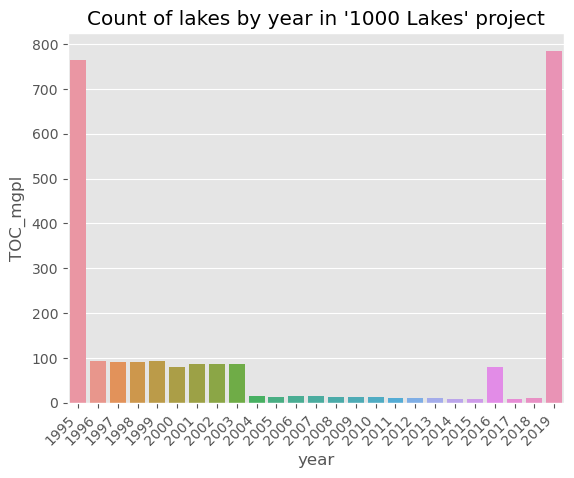

In [10]:
# For just the 1k Lakes, plot how many lakes are measured per year
agg_df = wc_df_1klakes.groupby("year").count()[["TOC_mgpl"]].reset_index()
ax = sn.barplot(data=agg_df, x="year", y="TOC_mgpl")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Count of lakes by year in '1000 Lakes' project");

As expected, for the "1000 Lakes" dataset we have lots of data in 1995 and 2019, but not much in-between (although nearly 100 lakes were monitored between 1996 and 2003, which is good).

### 1.2. Tidstrendsjøene

Tidstrendsjøene provide a detailed record of temporal changes for 78 sites across Norway. I'm a bit confused by the project names in Aquamonitor compared in RESA, but I think these lakes are part of the `BIOLOK` project in Aquamomonitor (**check this**). There might be other stations worth including here too - **ask Kari/Cathrine/Øyvind for suggestions for sites with good long-term montioring**.

The code below includes data from all the `BIOLOK` stations. **Check this - are these sites all "near-natural", or should they be filtered?**.

In [11]:
# Find the project code for the Tidstrendsjøer/Biolok project
proj_df = am.get_projects(token=token)
proj_df.query("project_name.str.contains('BIOLOK')", engine="python")

,project_id,project_code,project_name,description
844,7586,270022,BIOLOK,Vannkjemi på stasjoner som undersøkes av NINA


In [12]:
# Get water all chem between 1995 and 2019
proj_id = 7586
stn_df = am.get_project_stations(proj_id, token=token, return_coords=True)
wc_df_biolok = am.get_project_chemistry(proj_id, st_dt, end_dt, token=token)

In [13]:
# Map stations
nivapy.spatial.quickmap(stn_df, cluster=True, popup="station_id", kartverket=True)

In [14]:
# Tidy water chem
wc_df_biolok = tidy_water_chem(wc_df_biolok)

# Join station data
stn_df = stn_df[["station_id", "longitude", "latitude"]]
wc_df_biolok = pd.merge(wc_df_biolok, stn_df, how="left", on="station_id")
wc_df_biolok = nivapy.spatial.wgs84_dd_to_utm(
    wc_df_biolok, lat="latitude", lon="longitude", utm_zone=33
)
del wc_df_biolok["longitude"], wc_df_biolok["latitude"]
wc_df_biolok.dropna(subset=["utm_east"], inplace=True)
wc_df_biolok = wc_df_biolok[
    [
        "station_id",
        "station_name",
        "utm_north",
        "utm_east",
        "utm_zone",
        "year",
        "TOC_mgpl",
        "NO3_NO2_ugpl",
    ]
]

print(len(wc_df_biolok["station_id"].unique()), "unique stations in the dataset.")
wc_df_biolok.head()

/tmp/ipykernel_1915/2566034329.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["sample_date"].dt.year
/tmp/ipykernel_1915/2566034329.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["par_unit"] = df["parameter_name"] + "_" + df["unit"]
/tmp/ipykernel_1915/2566034329.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

78 unique stations in the dataset.


,station_id,station_name,utm_north,utm_east,utm_zone,year,TOC_mgpl,NO3_NO2_ugpl
0,26075,Måsabutjørna,6.860277e+06,299015.280352,33,1995,1.6,2.0
1,26075,Måsabutjørna,6.860277e+06,299015.280352,33,1996,1.9,4.0
2,26075,Måsabutjørna,6.860277e+06,299015.280352,33,1997,1.5,4.0
3,26075,Måsabutjørna,6.860277e+06,299015.280352,33,1998,1.7,3.0
4,26075,Måsabutjørna,6.860277e+06,299015.280352,33,1999,1.6,1.0


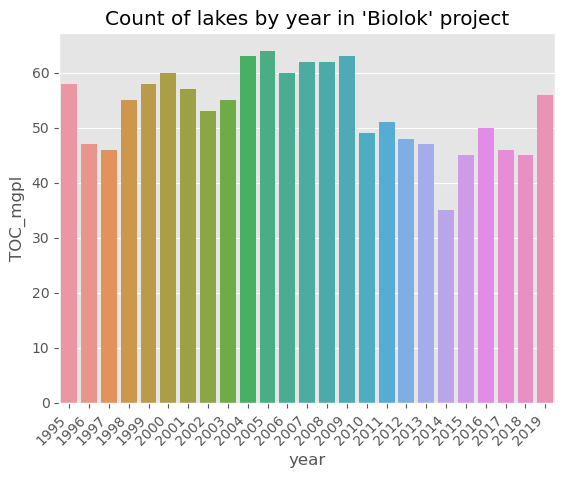

In [15]:
agg_df = wc_df_biolok.groupby("year").count()[["TOC_mgpl"]].reset_index()
ax = sn.barplot(data=agg_df, x="year", y="TOC_mgpl")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Count of lakes by year in 'Biolok' project");

### 1.3. Combine datasets

In [16]:
# Combine
df = pd.concat([wc_df_1klakes, wc_df_biolok], axis="rows")

# Some lakes are in both projects
df = df.drop_duplicates(subset=["station_id", "year"], keep="first").reset_index(
    drop=True
)
del df["utm_zone"]

# Save
df.to_csv("gam_data.csv", index=False)
df.head()

,station_id,station_name,utm_north,utm_east,year,TOC_mgpl,NO3_NO2_ugpl
0,26070,Langtjern,6.634299e+06,323345.999797,1995,11.7,46.0
1,26070,Langtjern,6.634299e+06,323345.999797,1996,19.6,13.0
2,26070,Langtjern,6.634299e+06,323345.999797,1997,11.0,54.0
3,26070,Langtjern,6.634299e+06,323345.999797,1998,13.1,58.0
4,26070,Langtjern,6.634299e+06,323345.999797,1999,13.1,53.0


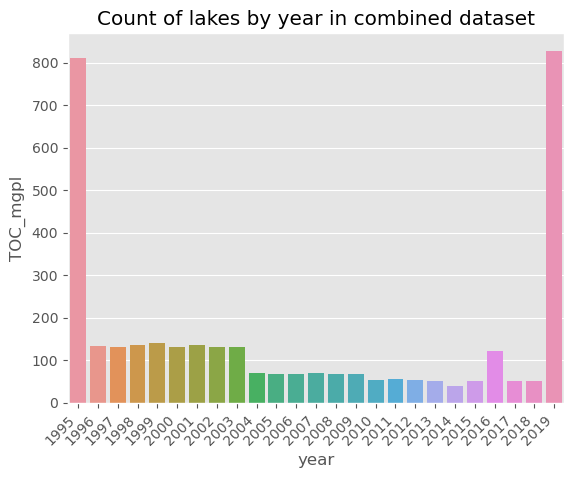

In [17]:
agg_df = df.groupby("year").count()[["TOC_mgpl"]].reset_index()
ax = sn.barplot(data=agg_df, x="year", y="TOC_mgpl")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Count of lakes by year in combined dataset");

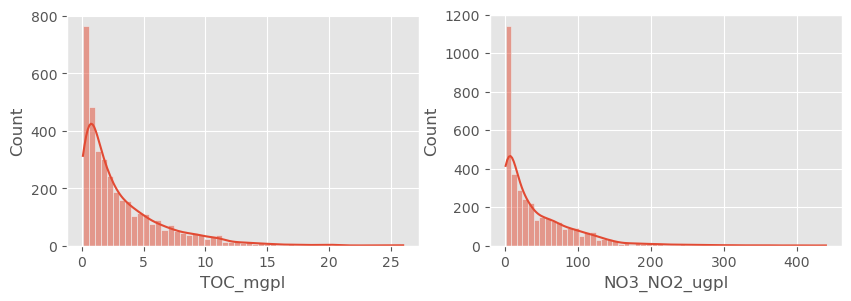

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
sn.histplot(data=df, x="TOC_mgpl", kde=True, ax=axes[0])
sn.histplot(data=df, x="NO3_NO2_ugpl", kde=True, ax=axes[1]);

The combined dataset comprises around 800 lakes for 1995 and 2019, and between 50 and 120 lakes per year for the period in between.

## 2. Explore statistical models

Using a GAM, we will model TOC and NO3 concentrations as the sum of (non-linear) functions of space and time. The most obvious approach is to use a 2D spline, `s(x, y)`, to model the spatial component, and a 1D spline, `s(t)`, to model variation over time. Note that when a 2D spline is defined in this way, it uses just a single smoothing parameter i.e. the same smoothing is applied in both the `x` and `y` directions. This seems reasonable as we are working in projected co-ordinates where `x` and `y` have the same scale (UTM Zone 33N metres). 

An alternative approach is to fit a tensor spline, either just for the spatial component,`te(x, y)`, or for the combined spatio-temporal variation, `te(x, y, t)`. Both these options will allow different smoothing factors in the `x`, `y` and `t` dimensions.

The first option, `Conc ~ s(x, y) + s(t)`, seems intuitively sensible and is probably simplest. However, the second option, `Conc ~ te(x, y, t)` has some additional flexibility and is also worth exploring.

### 2.1. Choosing `k`

Each spline takes a parameter `k`, which is the number of "knots". More "knots" means more flexibility, but it also increases the computational complexity of fitting and predicting. It is important that `k` is large enough to allow the model to fit patterns in the data. Furthermore, making `k` too large does not necessarily cause overfitting, due to the way the splines are penalised. The main drawback is the increase in processing time. See the documentation [here](https://rdrr.io/cran/mgcv/man/choose.k.html) for details. In particular:

> [...] exact choice of k is not generally critical: it should be chosen to be large enough that you are reasonably sure of having enough degrees of freedom to represent the underlying ‘truth’ reasonably well, but small enough to maintain reasonable computational efficiency. Clearly ‘large’ and ‘small’ are dependent on the particular problem being addressed.

`mgcv` includes a function called `gam.check` to help with selecting `k`. The output for a questionable model will look like this:

    Basis dimension (k) checking results. Low p-value (k-index<1) may
    indicate that k is too low, especially if edf is close to k'.

                             k'   edf k-index p-value    
    s(utm_east,utm_north) 29.00 28.15    0.37  <2e-16 ***
    s(year)                9.00  5.85    0.86  <2e-16 ***
    
In the output above note that, for both parameters, the value of `k` is close to the effective degrees of freedom (`edf`), the `k-index` is less than 1, and the `p-value` is small. This is **bad**. According to the documentation [here](https://www.rdocumentation.org/packages/mgcv/versions/1.8-41/topics/gam.check), a good strategy is to double the value of `k` and refit the model, and keep doing this until the `p-values` are **not** significant (which implies there is no significant structure in the residuals).

**Note:** `k` for each variable must be smaller than the number of unique values in the data for that variable. In the analysis here, `year` has only 25 unique values, so the most flexible spline possible is `s(year, k=24)`. This still results in significant structure in the residuals due to `year`, but I can't do anything about this and using `k=24` is still a big improvement compared to the default. For the spatial spline, using `k=600` seems to be necessary to fit patterns in the data. **This takes a long time**, but will hopefully produce a reasonable model in the end. For the tensor method, the total value of `k` is the *product* of `k1`, `k2` and `k3` (which are the number of knots for each dimension). In this case, using `k=c(15, 15, 4)` seems to offer a reasonable compromise, giving `k=900` overall, while adding more flexibility in the spatial dimensions than in the time dimension.

### 2.2. Other parameters

In addition to `k`, described above, the following parameters can be useful when fitting GAMs:

 * `family` defines the error distribution assumed in the model (Gaussian by default). Setting `family = scat()` can be a good choice for right-skewed data with heavy tails (e.g water chemsitry data). A good tip is to try without first, then check the Q-Q plot in `gam.check` and if the tails look poor, try `family = scat()` instead
 
 * `select = TRUE` allows some model coefficients to go to zero i.e. the model can automatically perform variable selection by setting some coefficients to zero
 
 * `method = "REML"` is usually the best choice for fitting the smoothing terms for the splines

The code below is passed directly to the R kernel.

In [19]:
%%R

# Load packages
suppressMessages(library(mgcv))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(viridis))

# Read dataset
df = read.csv("gam_data.csv")

### 2.2. Models for TOC

#### 2.2.1. Tensor model

Fit 

`TOC_mgpl ~ te(utm_east, utm_north, year, k=c(k1, k2, k3)` 

for different values of `k1`, `k2` and `k3`.

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
TOC_mgpl ~ te(utm_east, utm_north, year, k = c(15, 15, 4))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.19755    0.02785   114.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                              edf Ref.df     F p-value    
te(utm_east,utm_north,year) 306.5    654 17.79  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.762   Deviance explained = 78.2%
-REML = 7590.9  Scale est. = 2.8268    n = 3644
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-0.002887781,0.0004831558]
(score 7590.854 & scale 2.826832).
Hessian positive definite, eigenvalue range [0.0003149241,18

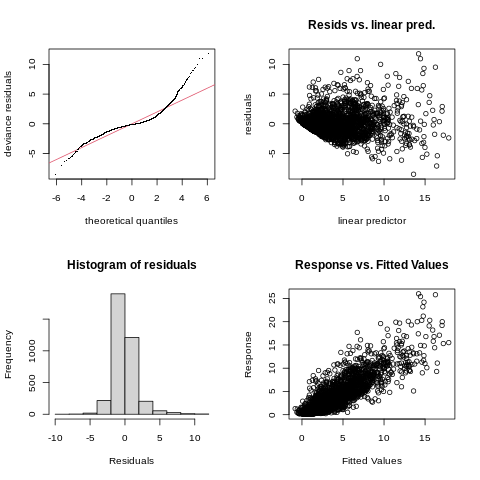

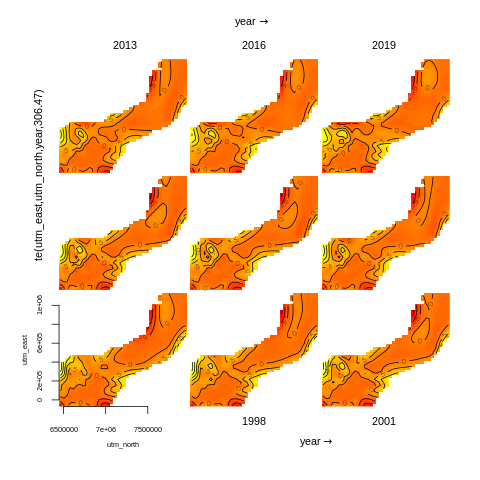

In [20]:
%%R

toc_ten_model = gam(TOC_mgpl ~ te(utm_east, utm_north, year, k = c(15, 15, 4)),
            data = df, select = TRUE, method = "REML")

print("# Fit summary #################################################")
print(summary(toc_ten_model))
print('')
print("# Diagnostic checks ###########################################")
gam.check(toc_ten_model)
concurvity(toc_ten_model, full=TRUE)

plot(toc_ten_model, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(toc_ten_model)[1])

saveRDS(toc_ten_model, "toc_tensor_model.rds")

#### 2.2.2. Spline model

Fit 

`TOC_mgpl ~ s(utm_east, utm_north, k=k1) + s(year, k=k2)` 

for different values of `k1` and `k2`.

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
TOC_mgpl ~ s(utm_east, utm_north, k = 700) + s(year, k = 24)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.19755    0.01799   177.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df     F p-value    
s(utm_east,utm_north) 598.225    699 46.76  <2e-16 ***
s(year)                 1.904     23 13.26  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =    0.9   Deviance explained = 91.7%
-REML =   6572  Scale est. = 1.1796    n = 3644
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 15 iterations.
Gradient range [-0.0002882557,0.0001090654]
(score 6572.016 & scale 1.179648).
eigenvalu

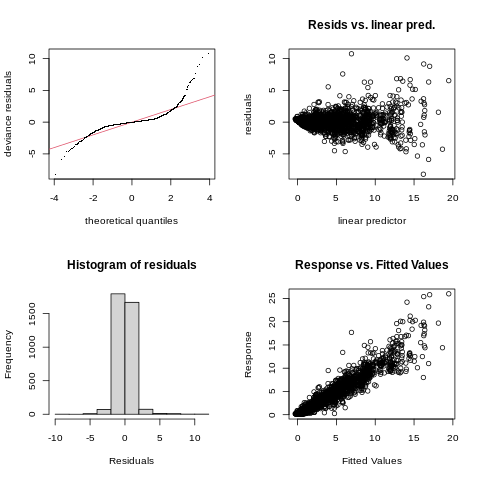

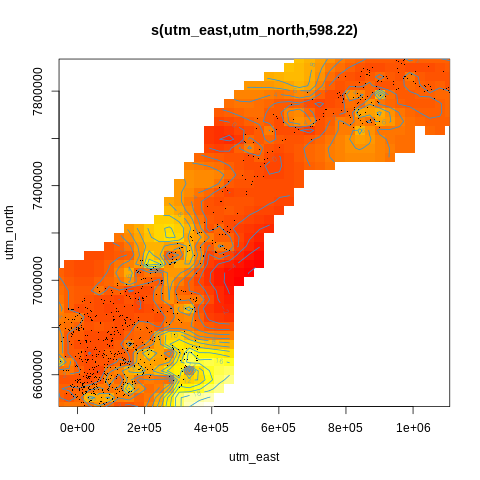

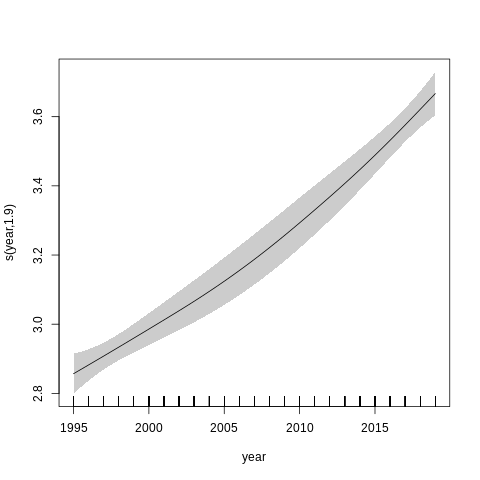

In [21]:
%%R

toc_spl_model = gam(TOC_mgpl ~ s(utm_east, utm_north, k=700) + s(year, k=24),
            data=df, select = TRUE, method = "REML")

print("# Fit summary #################################################")
print(summary(toc_spl_model))
print('')
print("# Diagnostic checks ###########################################")
gam.check(toc_spl_model)
concurvity(toc_spl_model, full=TRUE)

plot(toc_spl_model, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(toc_spl_model)[1])

saveRDS(toc_spl_model, "toc_spline_model.rds")

In [22]:
%%R

AIC(toc_ten_model, toc_spl_model)

                    df      AIC
toc_ten_model 313.2537 14433.20
toc_spl_model 603.8406 11494.01


### 2.3. Models for NO3

#### 2.3.1. Tensor model

Fit 

`NO3_NO2_ugpl ~ te(utm_east, utm_north, year, k=c(k1, k2, k3)` 

for different values of `k1`, `k2` and `k3`.

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
NO3_NO2_ugpl ~ te(utm_east, utm_north, year, k = c(15, 15, 4))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  43.3076     0.4827   89.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                              edf Ref.df     F p-value    
te(utm_east,utm_north,year) 257.7    658 11.63  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.677   Deviance explained =   70%
-REML =  17886  Scale est. = 849.31    n = 3645
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-0.003985272,0.0001322187]
(score 17886.11 & scale 849.3052).
eigenvalue range [-3.971792e-05,1825.281].
Model rank = 

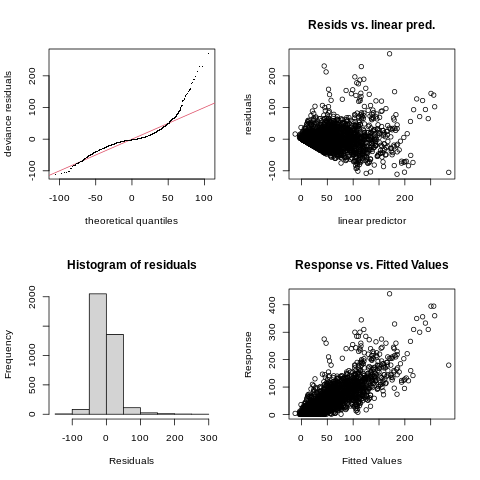

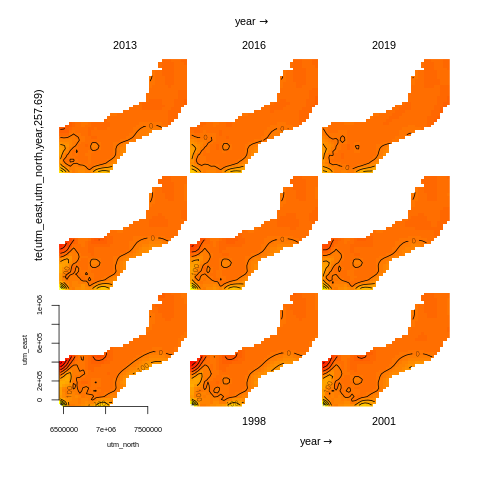

In [23]:
%%R

no3_ten_model = gam(NO3_NO2_ugpl ~ te(utm_east, utm_north, year, k=c(15, 15, 4)),
            data=df, select = TRUE, method = "REML")

print("# Fit summary #################################################")
print(summary(no3_ten_model))
print('')
print("# Diagnostic checks ###########################################")
gam.check(no3_ten_model)
concurvity(no3_ten_model, full=TRUE)

plot(no3_ten_model, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(no3_ten_model)[1])

saveRDS(no3_ten_model, "no3_tensor_model.rds")

#### 2.3.2. Spline model

Fit 

`NO3_NO2_ugpl ~ s(utm_east, utm_north, k=k1) + s(year, k=k2)` 

for different values of `k1` and `k2`.

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
NO3_NO2_ugpl ~ s(utm_east, utm_north, k = 700) + s(year, k = 24)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  43.3076     0.4217   102.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df     F p-value    
s(utm_east,utm_north) 448.503    699 14.91  <2e-16 ***
s(year)                 5.031     23 26.07  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.754   Deviance explained = 78.5%
-REML =  17634  Scale est. = 648.1     n = 3645
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 12 iterations.
Gradient range [-0.005749581,0.003775569]
(score 17634.01 & scale 648.0992).
Hessian

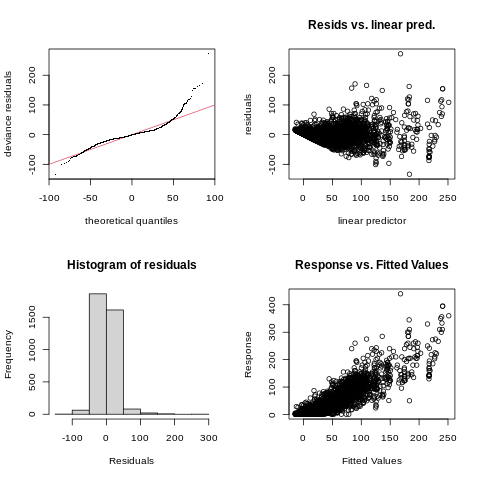

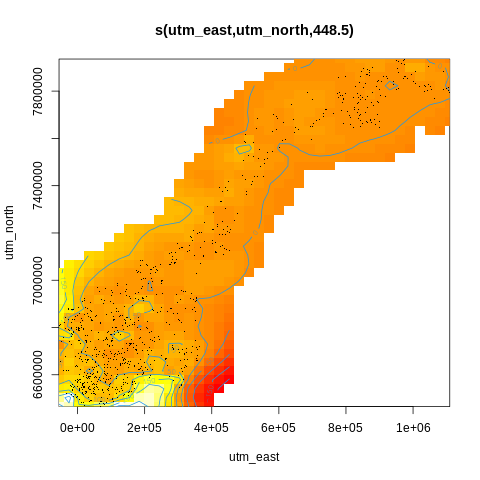

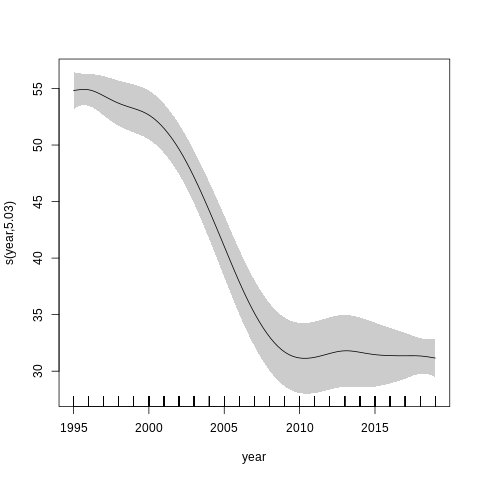

In [24]:
%%R

no3_spl_model = gam(NO3_NO2_ugpl ~ s(utm_east, utm_north, k=700) + s(year, k=24),
            data=df, select = TRUE, method = "REML")

print("# Fit summary #################################################")
print(summary(no3_spl_model))
print('')
print("# Diagnostic checks ###########################################")
gam.check(no3_spl_model)
concurvity(no3_spl_model, full=TRUE)

plot(no3_spl_model, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(no3_spl_model)[1])

saveRDS(no3_spl_model, "no3_spline_model.rds")

In [25]:
%%R

AIC(no3_ten_model, no3_spl_model)

                    df      AIC
no3_ten_model 265.8233 35190.79
no3_spl_model 457.7075 34371.89


Note the following based on the output above:

 * All models are highly significant ($p \approx 0$ for all variables)

 * The tensor-only models are faster to fit than the spline models. They also pass all the diagnostic checks whereas, for the spline models, `k` for `year` is still too low even when increased to the maximum value of 24
 
 * Despite these issues, residuals for the spline models look more-or-less OK to me. I also like being able to explicitly separate the spatial from the temporal effects
 
 * Performance is similar for all models
 
| Parameter |  Model |  R2  |
|:---------:|:------:|:----:|
|    TOC    | Tensor | 0.82 |
|    TOC    | Spline | 0.87 |
|    NO3    | Tensor | 0.76 |
|    NO3    | Spline | 0.75 |

 * Based on this, **I will initially use the spline models for prediction**

 * The spatial splines, `s(x, y)`, suggest NO3 is highest in Southern Norway. TOC is highest in South-eastern Norway, but there are also high values in the far north (Finnmark) and mid-west (around Trondheim)
 
 * The temporal splines, `s(t)`, suggest NO3 concentrations have declined rapidly from 1995 to around 2010, followed by a leveling-off to 2019. For TOC, concentrations have increased fairly steadily (but they may be increasing faster in more recent years)

## 3. Setup prediction grid

We want to be able to predict TOC and NO3 concentrations for any location and year in Norway between 1995 and 2019. The code below defines a regular, square grid across the whole of Norway that can be used for prediction.

In [26]:
# Setup output grid
# Bounding box for Norway in ETRS89-based UTM zone 33N
west, east, south, north = -90000, 1140000, 6430000, 7955000
extent = (west, east, south, north)

# Output resolution in m
spacing = 1000

# Build grid
xx, yy = vd.grid_coordinates(region=extent, spacing=spacing, pixel_register=True)

# Flatten to dataframe
grid_df = pd.DataFrame({"utm_east": xx.flatten(), "utm_north": yy.flatten()})
grid_df.head()

,utm_east,utm_north
0,-89500.0,6430500.0
1,-88500.0,6430500.0
2,-87500.0,6430500.0
3,-86500.0,6430500.0
4,-85500.0,6430500.0


## 4. Make predictions

The code in this section uses the statistical models from Section 2 to predict values for each cell centre for each year. The standard error for each prediction is also stored. 

Predictions are made using `mgcv` in R and results are then put together in Python and converted into a georeferenced `xarray` dataset (i.e. a netCDF). The R script takes two arguments: the parameter name (either `TOC_mgpl` or `NO3_NO2_ugpl`) and the type of model to fit (either `tensor` or `spline`):

 * If `tensor`, the model is fit as `par ~ te(utm_east, utm_north, year, k=c(15, 15, 4))`
 
 * If `spline`, it's `par ~ s(utm_east, utm_north, k=600) + s(year, k=24)`

**Note:** Predicting on a 1 km by 1 km grid is slow - **the code below will take several hours to run**.

In [28]:
model_type = "spline"
pars = ["TOC_mgpl", "NO3_NO2_ugpl"]
years = range(st_yr, end_yr + 1)

# Get approx. boundary of Norway. Useful for clipping the predictions, as the splines
# can go a bit wild for locations far away from data points. Use the vassdragsområder,
# as these extend offshore a bit, so we don't have to worry about coastline details
vassom_gdf = nivapy.da.read_postgis("physical", "norway_nve_vassdragomrade_poly", eng)
vassom_gdf = vassom_gdf.dissolve()

ds_list = []
for par in pars:
    print("Processing", par)
    pred_list = []
    stderr_list = []
    for year in years:
        print("  ", year)

        # Build df of prediction points for year
        grid_df_yr = grid_df.copy()
        grid_df_yr["year"] = year
        grid_df_yr.to_csv("grid_df_yr.csv", index=False)

        # Predict with R
        cmd = [
            "Rscript",
            "--vanilla",
            "predict_mgcv.R",
            par,
            model_type,
        ]
        subprocess.check_call(cmd)

        # Read predictions and reshape
        pred_df = pd.read_csv("preds.csv")
        pred_list.append(pred_df["predicted"].values.reshape(xx.shape))
        stderr_list.append(pred_df["stderr"].values.reshape(xx.shape))

    # Stack data for all years into DataArray
    data = np.dstack(pred_list)
    stderr = np.dstack(stderr_list)
    da = xr.DataArray(data, coords=[yy[:, 0], xx[0], years], dims=["y", "x", "year"])
    da_err = xr.DataArray(
        stderr, coords=[yy[:, 0], xx[0], years], dims=["y", "x", "year"]
    )

    # Convert to Dataset
    ds = da.to_dataset(name=par)
    ds_err = da_err.to_dataset(name=f"{par}_stderr")
    ds_list.append(ds)
    ds_list.append(ds_err)

os.remove("grid_df_yr.csv")
os.remove("preds.csv")

# Merge datasets
ds = xr.merge(ds_list)

# Add geospatial info
ds = ds.rio.write_crs("epsg:25833")
ds = ds.rio.write_transform()

# Set negative values to 0
ds = ds.where(ds > 0, 0)

# Clip to vassdragsområder
ds = ds.rio.clip(vassom_gdf.geometry.values, vassom_gdf.crs, drop=True, invert=False)

# Set NoData value and convert to 32-Bit
for par, _ in ds.items():
    ds[par].rio.write_nodata(-9999, encoded=True, inplace=True)
    ds[par] = ds[par].astype("float32")

ds.to_netcdf(nc_path)

ds

Processing TOC_mgpl
   1995
   1996
   1997
   1998
   1999
   2000
   2001
   2002
   2003
   2004
   2005
   2006
   2007
   2008
   2009
   2010
   2011
   2013
   2014
   2015
   2016
   2017
   2018
   2019
Processing NO3_NO2_ugpl
   1995
   1996
   1997
   1998
   1999
   2000
   2001
   2002
   2003
   2004
   2005
   2006
   2007
   2008
   2009
   2010
   2011
   2012
   2013
   2014
   2015
   2016
   2017
   2018
   2019


<xarray.Dataset>
Dimensions:              (y: 1496, x: 1198, year: 25)
Coordinates:
  * y                    (y) float64 6.446e+06 6.448e+06 ... 7.94e+06 7.942e+06
  * x                    (x) float64 -7.95e+04 -7.85e+04 ... 1.116e+06 1.118e+06
  * year                 (year) int64 1995 1996 1997 1998 ... 2017 2018 2019
    spatial_ref          int64 0
Data variables:
    TOC_mgpl             (y, x, year) float32 nan nan nan nan ... nan nan nan
    TOC_mgpl_stderr      (y, x, year) float32 nan nan nan nan ... nan nan nan
    NO3_NO2_ugpl         (y, x, year) float32 nan nan nan nan ... nan nan nan
    NO3_NO2_ugpl_stderr  (y, x, year) float32 nan nan nan nan ... nan nan nan

In [29]:
# Save examples to GeoTiff
year = 2015
ds["TOC_mgpl"].sel(year=year).rio.to_raster(f"TOC_{year}.tif")
ds["NO3_NO2_ugpl"].sel(year=year).rio.to_raster(f"NO3_{year}.tif")

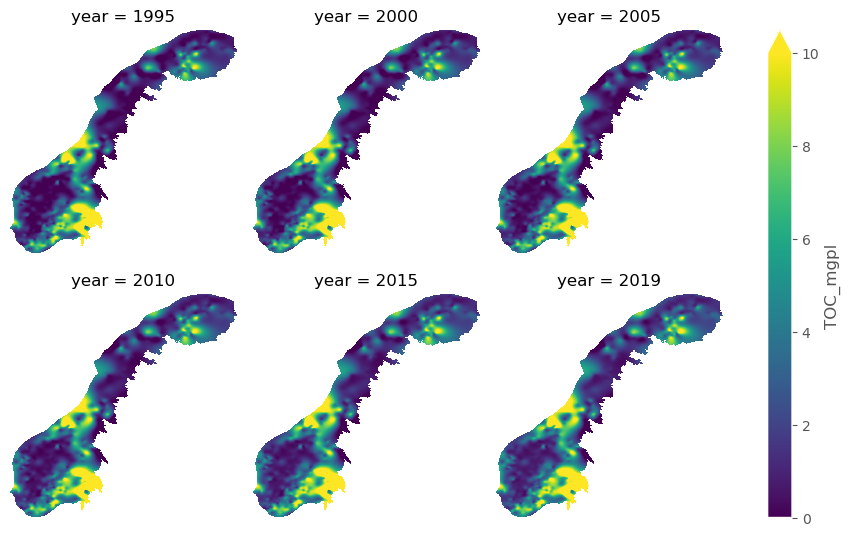

In [30]:
# Maps every ~5 years for TOC
axes = (
    ds["TOC_mgpl"]
    .sel(year=[1995, 2000, 2005, 2010, 2015, 2019])
    .plot(col="year", vmax=10, col_wrap=3)
)
for ax in axes.axes.flatten():
    ax.axis("off")

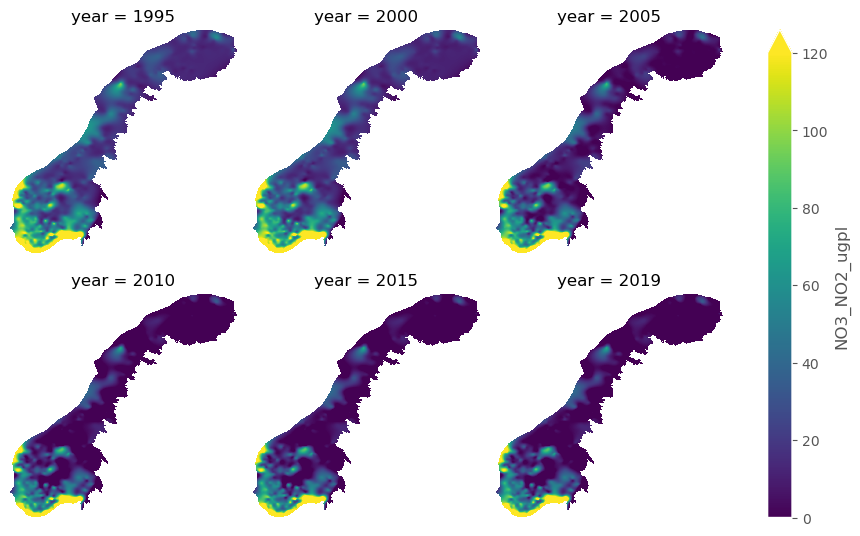

In [31]:
# Maps every ~5 years for NO3
axes = (
    ds["NO3_NO2_ugpl"]
    .sel(year=[1995, 2000, 2005, 2010, 2015, 2019])
    .plot(col="year", vmax=120, col_wrap=3)
)
for ax in axes.axes.flatten():
    ax.axis("off")

The code below randomly selects sites from the `BIOLOK` project and plots the observed time series overlaid with the predicted curve. 2-sigma (~95%) confidence intervals for the predictions are also shown.

**Note:** This comparison should be improved by finding some independent data from stations not included in the fitting. **The comparison below uses data included in the model training, so it does not reflect "out-of-sample" predictive performance**.

`TOC (mg/l)` is shown in the left column and `NO3-N (ug/l)` is shown in the right column.

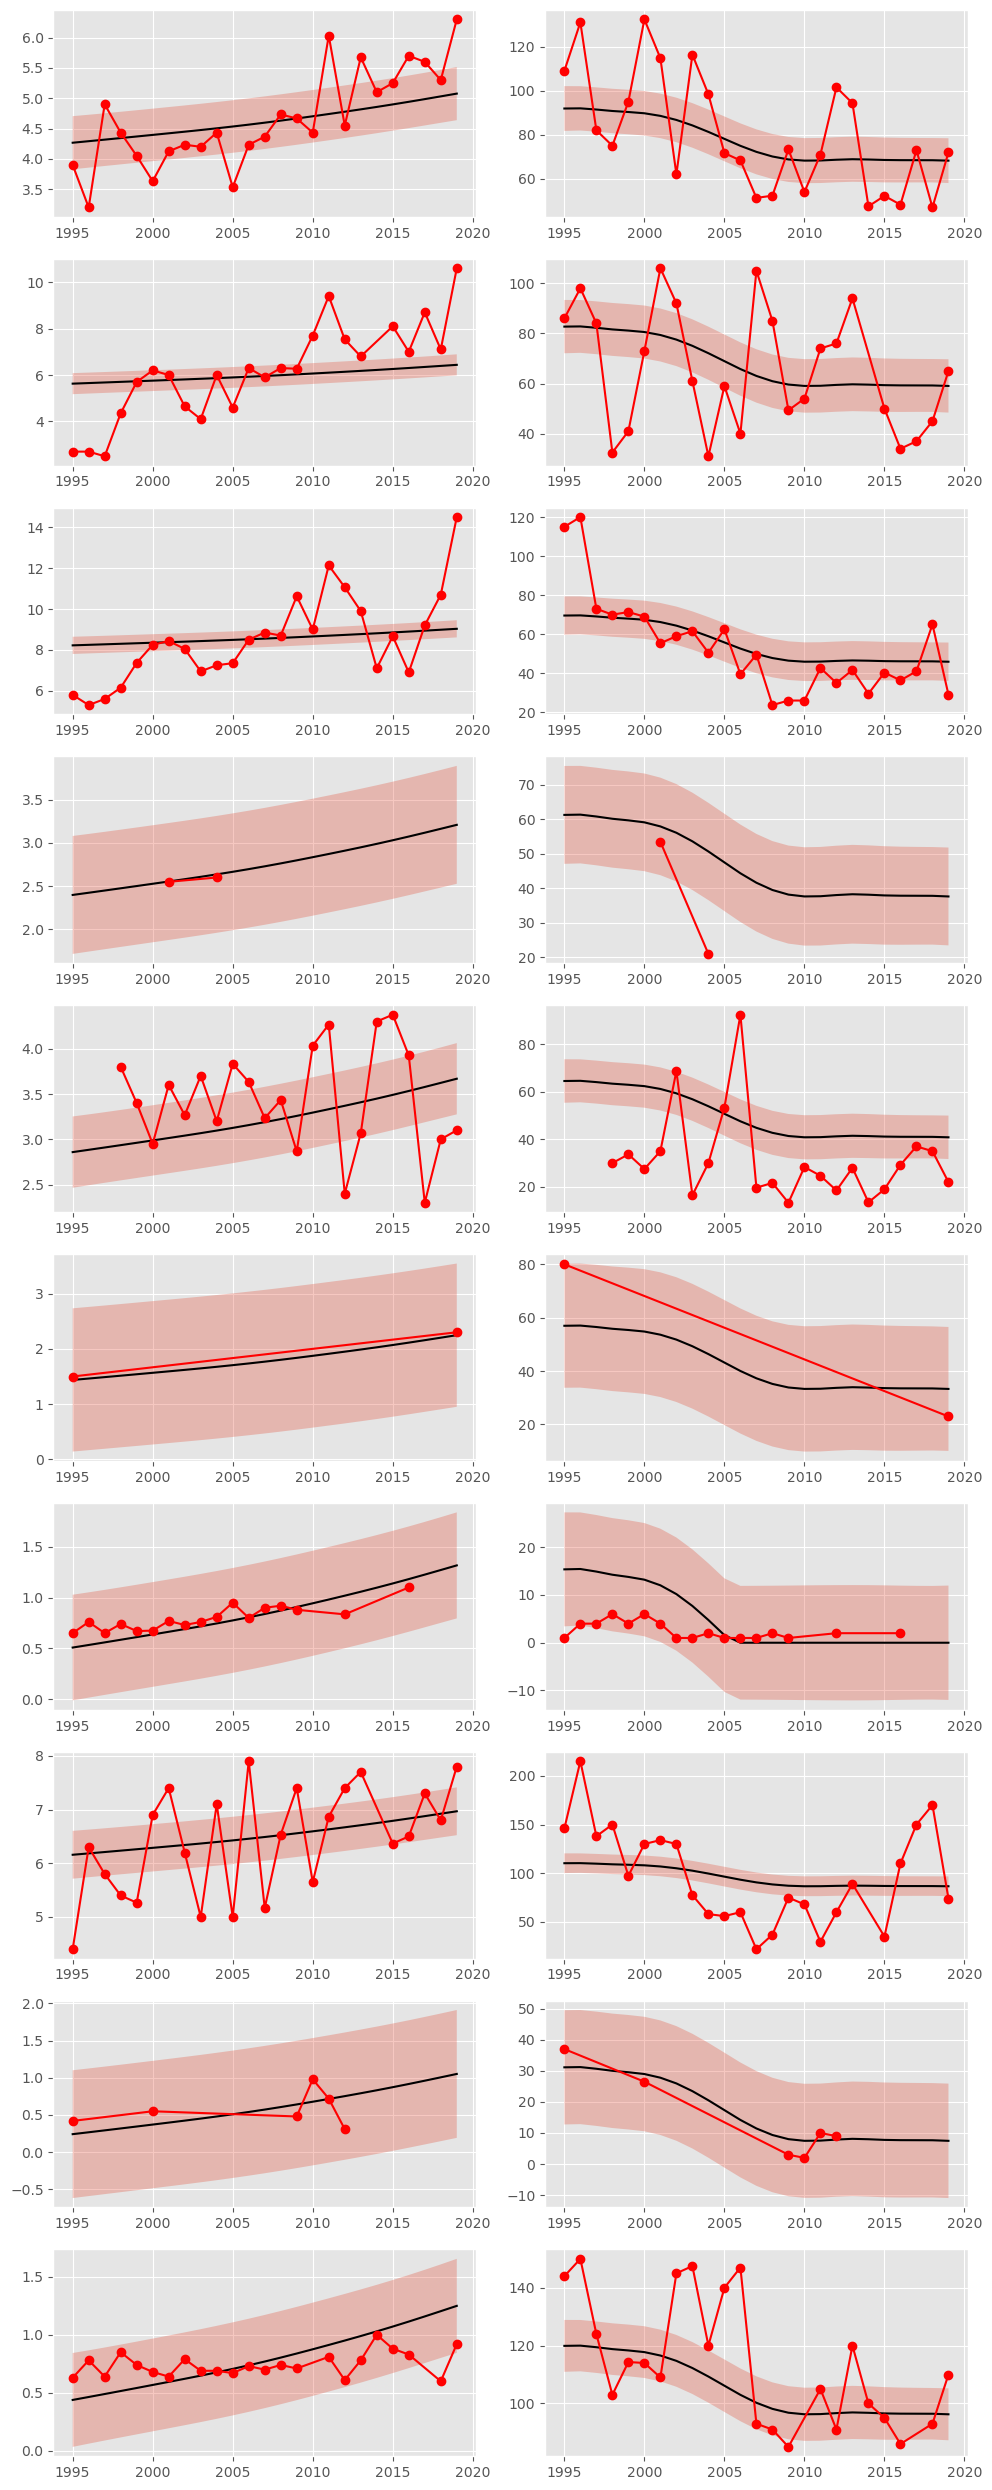

In [32]:
# Randomly select Biolok stations for comparison
n_stns = 10
plot_stns = stn_df.sample(n=n_stns)

fig, axes = plt.subplots(nrows=len(plot_stns), ncols=2, figsize=(10, 25))
for idx, stn_id in enumerate(plot_stns["station_id"]):
    # Get oberved data
    obs_df = df.query("station_id == @stn_id").sort_values("year")

    # Get modelled data
    mod_df = (
        ds.sel(
            x=obs_df.iloc[0]["utm_east"],
            y=obs_df.iloc[0]["utm_north"],
            method="nearest",
        )
        .to_dataframe()
        .reset_index()
    )

    # Loop over pars
    par_list = ["TOC_mgpl", "NO3_NO2_ugpl"]
    for par_idx, par in enumerate(par_list):
        mod_df[f"{par}_lower"] = mod_df[par] - 2 * mod_df[f"{par}_stderr"]
        mod_df[f"{par}_upper"] = mod_df[par] + 2 * mod_df[f"{par}_stderr"]

        # Plot modelled
        axes[idx, par_idx].fill_between(
            mod_df["year"],
            mod_df[f"{par}_lower"],
            mod_df[f"{par}_upper"],
            alpha=0.3,
            label="95% CI",
        )
        axes[idx, par_idx].plot(mod_df["year"], mod_df[par], "k-", label="Modelled")

        # Plot obs
        axes[idx, par_idx].plot(obs_df["year"], obs_df[par], "ro-", label="Observed")

plt.tight_layout()

## Summary

This notebook fits a simple spatio-temporal model to predict TOC and NO3 concentrations in near-natural surface waters for any year and location in Norway between 1995 and 2019. The output is stored on the JupoyterHub as a netCDF here: `/home/jovyan/shared/critical_loads/norway_interpolated_toc_no3_1995-2019.nc`.

 * Model performance seems reasonable using just location (UTM Zone 33N `x` and `y` co-ordinates) and time (mean annual concentration). Using additional co-variates will probably make them better, though
 
 * Input data should be more carefully screened
 
 * The models should be independently validated using data from stations not included in the fitting process